# **Actividad 6**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas.util.testing as tm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

**1. Estacionaridad**

In [3]:
#Leemos el archivo de datos de la estación climatológica para crear un dataframe con la biblioteca Pandas
url = "https://raw.githubusercontent.com/TonyReyesM/Fisica-Computacional/master/Actividad%201/Datos%20diarios%203074.txt"
df = pd.read_csv(url)

#Los datos comienzan en el renglon 19.
#El último renglón del archivo no tiene datos
#Los nombres de las 5 columnas son "Fecha", "Precip (mm)", "Evap (mm)", "Tmax (ºC)", "Tmin (ºC)"
#Creamos una lista de los nombres de las 5 columnas
columnas = ['Fecha','Precip','Evap','Tmax','Tmin']
#Creamos el nuevo dataframe sin los primeros 15 renglones ni el último renglón
clima = pd.read_csv(url, names=columnas, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')
#Visualizamos el dataframe creado
#clima
#Exploramos el principio y el final del dataframe
#print(clima.head(10))
#print(clima.tail(10))

#Analizamos las dimensiones del dataframe y vemos los renglones y las columnas respectivamente.
#clima.shape

#Creamos una copia del dataframe para trabajar con ella y no modificar el original
clima_cp0 = clima.copy()
#clima_cp0.head()

#Remplazamos con un espacio en blanco los valores donde esté escrito "Nulo"
clima_cp1 = clima_cp0.replace(to_replace = 'Nulo',value = '', regex = True)

#Convertimos a datos numéricos la información de las columnas de precipitación, evaporación, temperatura máxima, y temperatura mínina
#Utilizamos una iteración para cambiar los datos de cada columna de una por una
for i in columnas[1:]:
  clima_cp1[i] = pd.to_numeric(clima_cp1[i], errors = 'coerce')

#Visualizamos los primeros datos del dataframe para verificar que se realizaron los cambios
#clima_cp1.head()

#Revisamos la información que hay en el dataframe nuevo
#clima_cp1.info()

#Revisamos la cantidad de datos faltantes que hay en el archivo
#clima_cp1.isnull().sum()

#Revisamos el principio y final del dataframe
#print(clima_cp1.head())
#print(clima_cp1.tail())

#Hacemos un análisis estadístico con 3 cifras significativas del dataframe para después interpretarlo
#clima_cp1.describe().round(3)

#Ahora cambiaremos la información de la columna de fechas para cambiarlos a un formato de fecha y tiempo que python reconozca
#Primero generamos una copia del dataframe por si hay necesidad de utilizarlo de nuevo
clima_cp2 = clima_cp1.copy()

#Cambiamos los valores de la columna de fechas con el día al principio
clima_cp2['Fecha'] = pd.to_datetime(clima['Fecha'], dayfirst = True)
#print(clima_cp2.head())

#Revisamos los tipos de variables que hay en cada columna
#clima_cp2.dtypes

#Creamos dos nuevas columnas para el año y el mes
clima_cp2['Año'] = clima_cp2['Fecha'].dt.year
clima_cp2['Mes'] = clima_cp2['Fecha'].dt.month

#Revisamos el dataframe
#print(clima_cp2.head())
#print(clima_cp2.tail())

#Revisamos la información en las columnas de año y mes y que sean de valores enteros
#clima_cp2.info()

#Creamos el archivo con el que trabajaremos para la siguiente actividad
#Revisamos la información en el archivo e imprimimos los primeros y los últimos datos
dat_meteor = clima_cp2.copy()
#dat_meteor.info()
#print(dat_meteor.head())
#print(dat_meteor.tail())

#Eliminamos la columna "Mes" para crear una nueva que denote cada mez con su nombre en lugar de un entero utilizando la función dt.strftime(%b)
#donde %b sirve para representar los meses por sus nombres
dat_meteor.drop("Mes", axis=1, inplace=True)
dat_meteor['Mes'] = dat_meteor['Fecha'].dt.strftime('%b')
#dat_meteor.info()
#print(dat_meteor.head())
#print(dat_meteor.tail())

#Creamos una copia del dataframe para que sea nuestra serie de tiempo, de la cual la variable "Fecha" será el nuevo índice
dat_meteorTS = dat_meteor.copy()
dat_meteorTS = dat_meteorTS.set_index('Fecha')
#Revisamos que lo que hicimos es lo deseado
dat_meteorTS.info()
#print(dat_meteorTS.head())
#print(dat_meteorTS.tail())

#Seleccionaremos un conjunto de años de 30 años  
#El archivo tiene datos desde 1940 hasta el 2017, así que tomaremos desde 1988 hasta el 2017, de 1958 a 1987, y de 1940 a 1957 para tener un conjunto de series de tiempo 
dat_metTS1 = dat_meteorTS[(dat_meteorTS['Año'] >= 1940) & (dat_meteorTS['Año'] <= 1957)]
dat_metTS2 = dat_meteorTS[(dat_meteorTS['Año'] >= 1958) & (dat_meteorTS['Año'] <= 1987)]
dat_metTS3 = dat_meteorTS[(dat_meteorTS['Año'] >= 1988) & (dat_meteorTS['Año'] <= 2017)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27175 entries, 1940-01-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  26956 non-null  float64
 1   Evap    24242 non-null  float64
 2   Tmax    27165 non-null  float64
 3   Tmin    27166 non-null  float64
 4   Año     27175 non-null  int64  
 5   Mes     27175 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ MB


In [4]:
#Definimos la función que prueba la estacionaridad de una serie de tiempo
def test_stationarity(sTiempo):
    #Determinar la Estadística de promedios móviles
    promMov = sTiempo.rolling(window=365, center=True).mean()
    stdMov = sTiempo.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(sTiempo, color='blue',label='Original')
    plt.plot(promMov, color='red', label='Promedio móvil')
    plt.plot(stdMov, color='black', label = 'Desviación estándar móvil')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(sTiempo, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [5]:
#Creamos la primer serie de Tiempo para analizar,  
#Fechas de inicio y fin, para filtrar la información
start, end = '2012-01', '2017-12'
TS = dat_metTS3.loc[start:end].copy()
TS.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2012-01-01,0.0,3.7,25.4,9.0,2012,Jan
2012-01-02,0.0,3.5,27.0,10.0,2012,Jan
2012-01-03,0.0,4.8,26.3,10.0,2012,Jan
2012-01-04,0.0,4.5,29.0,13.8,2012,Jan
2012-01-05,0.0,4.6,27.4,13.8,2012,Jan


In [6]:
#Creamos la serie de tiempo para Tmax y Tmin
ts_Tmax = TS['Tmax'].copy()
ts_Tmin = TS['Tmin'].copy()
#Revisamos sus encabezados
print(ts_Tmax.head())
print(ts_Tmin.head())

Fecha
2012-01-01    25.4
2012-01-02    27.0
2012-01-03    26.3
2012-01-04    29.0
2012-01-05    27.4
Name: Tmax, dtype: float64
Fecha
2012-01-01     9.0
2012-01-02    10.0
2012-01-03    10.0
2012-01-04    13.8
2012-01-05    13.8
Name: Tmin, dtype: float64


***Temperatura máxima***

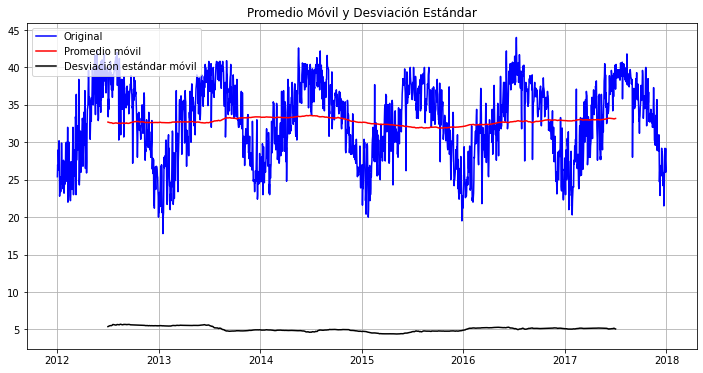

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.966337
p-value                           0.038160
#Lags Used                       14.000000
Number of Observations Used    2175.000000
Critical Value (1%)              -3.433360
Critical Value (5%)              -2.862870
Critical Value (10%)             -2.567478
dtype: float64


In [7]:
#Revisamos la estacionaridad de Tmax
test_stationarity(ts_Tmax)

El valor p es menor a 0.05, lo que indica estacionaridad en la serie

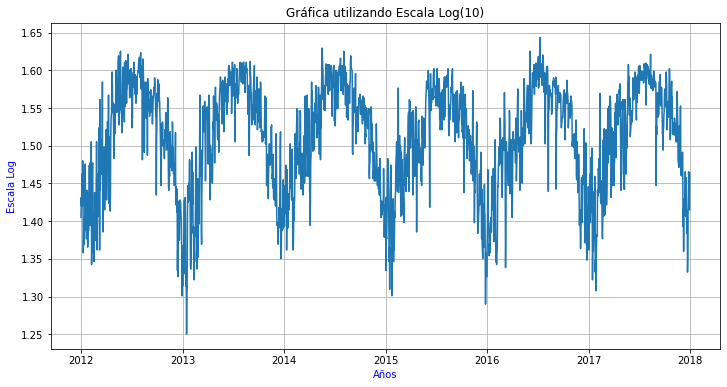

In [8]:
#Creamos una versión a escala logarítmica de la serie de tiempo y la graficamos
ts_TmaxLog = np.log10(ts_Tmax)
plt.plot(ts_TmaxLog)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

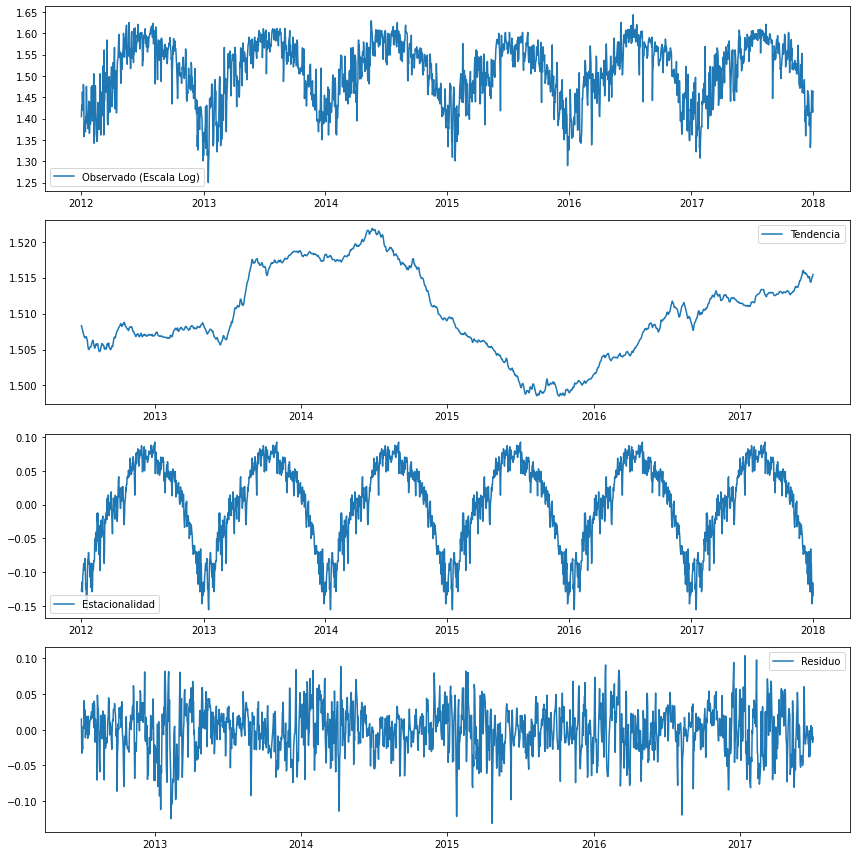

In [9]:
#Descomponemos la serie de tiempo para la temperatura máxima
decompTmax = sm.tsa.seasonal_decompose(ts_TmaxLog.interpolate(), model='additive', freq=365)

#La función regresa 3 componentes: tendencia, estacionalidad y un residuo
trendTmax = decompTmax.trend
seasonTmax = decompTmax.seasonal
resTmax = decompTmax.resid

#Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_TmaxLog, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trendTmax, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonTmax, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(resTmax, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

Observamos que la estacionalidad domina.

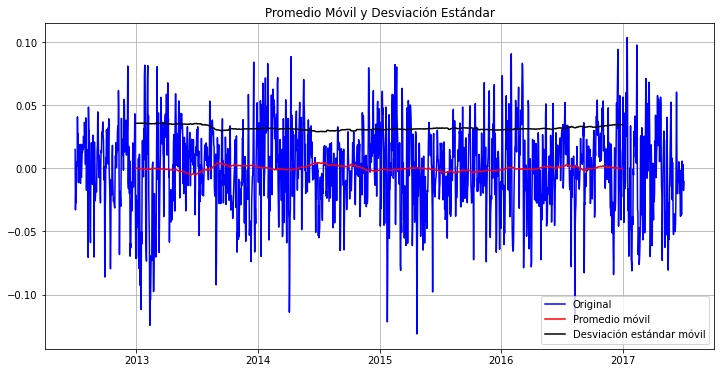

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -20.384430
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1824.000000
Critical Value (1%)              -3.433940
Critical Value (5%)              -2.863126
Critical Value (10%)             -2.567614
dtype: float64


In [10]:
#Revisamos la estacionaridad del residuo 
resTmax.dropna(inplace=True)
test_stationarity(resTmax)

Vemos que el valor p es menor a 0.05 por lo que el residuo cumple con la estacionaridad.

***Temperatura mínima***

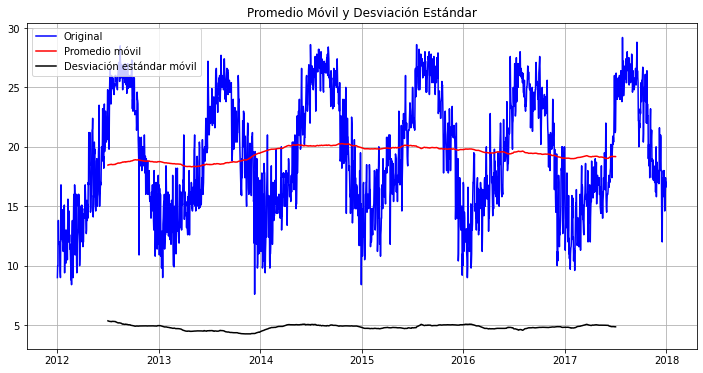

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.793417
p-value                           0.059220
#Lags Used                       14.000000
Number of Observations Used    2175.000000
Critical Value (1%)              -3.433360
Critical Value (5%)              -2.862870
Critical Value (10%)             -2.567478
dtype: float64


In [11]:
#Revisamos la estacionaridad de Tmin
test_stationarity(ts_Tmin)

El valor p es mayor a 0.05, por lo que la serie de tiempo no es estacionaridad

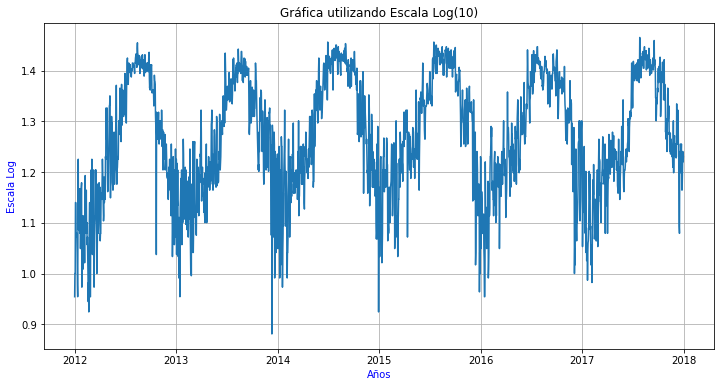

In [12]:
#Creamos una versión a escala logarítmica de la serie de tiempo y la graficamos
ts_TminLog = np.log10(ts_Tmin)
plt.plot(ts_TminLog)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

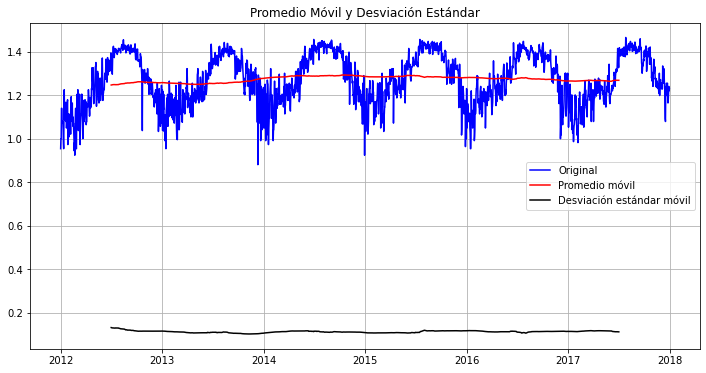

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.903163
p-value                           0.044981
#Lags Used                       13.000000
Number of Observations Used    2176.000000
Critical Value (1%)              -3.433359
Critical Value (5%)              -2.862869
Critical Value (10%)             -2.567478
dtype: float64


In [13]:
#Revisamos la estacionaridad de Tmin a escala logarítmica
test_stationarity(ts_TminLog)

El valor p es menor a 0.05, por lo que podemos decir que la serie de tiempo a escala logarítmica es **estacionaria**

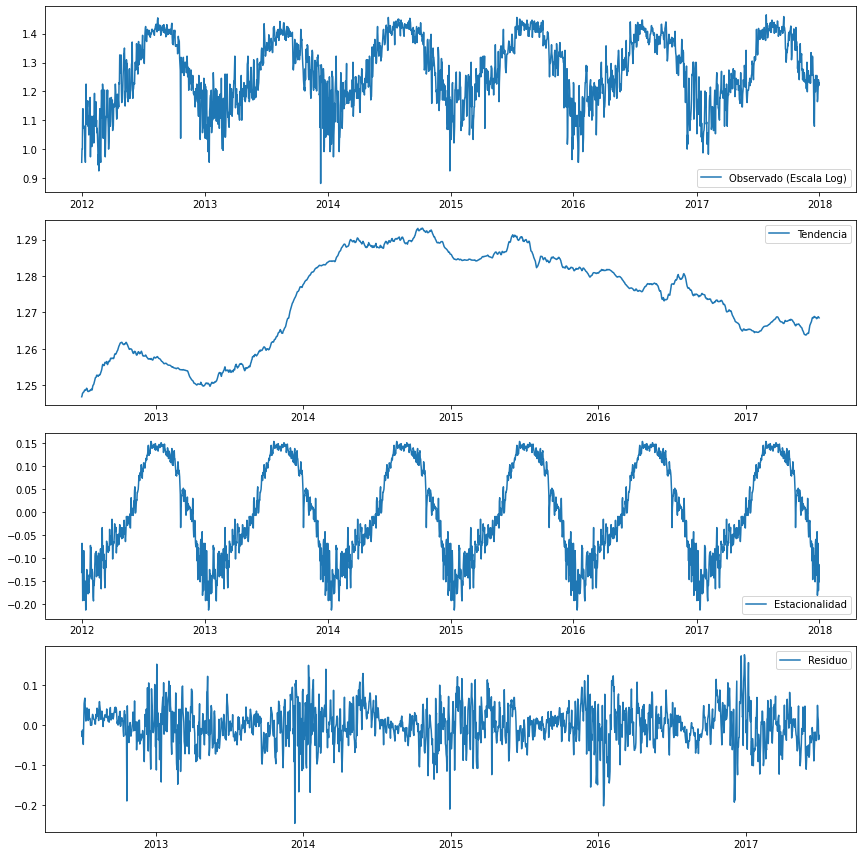

In [14]:
#Descomponemos la serie de tiempo para la temperatura máxima
decompTmin = sm.tsa.seasonal_decompose(ts_TminLog.interpolate(), model='additive', freq=365)

#La función regresa 3 componentes: tendencia, estacionalidad y un residuo
trendTmin = decompTmin.trend
seasonTmin = decompTmin.seasonal
resTmin = decompTmin.resid

#Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_TminLog, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trendTmin, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonTmin, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(resTmin, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

Observamos que la estacionalidad domina

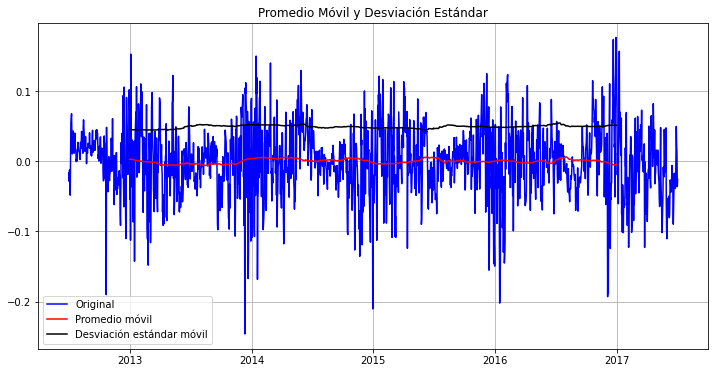

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.729951e+00
p-value                        3.211731e-14
#Lags Used                     1.400000e+01
Number of Observations Used    1.811000e+03
Critical Value (1%)           -3.433966e+00
Critical Value (5%)           -2.863137e+00
Critical Value (10%)          -2.567620e+00
dtype: float64


In [17]:
#Revisamos la estacionaridad del residuo 
resTmin.dropna(inplace=True)
test_stationarity(resTmin)

Vemos que el valor p es menor a 0.05 por lo que el residuo cumple con la estacionaridad.

**2. Pronostico de serie de tiempo**

***Temperatura máxima***

In [18]:
#Diferenciamos usando la función df.shift(), y eliminamos valores nulos
ts_TmaxLog_diff = ts_TmaxLog - ts_TmaxLog.shift(periods=7)
ts_TmaxLog_diff.dropna(inplace=True)

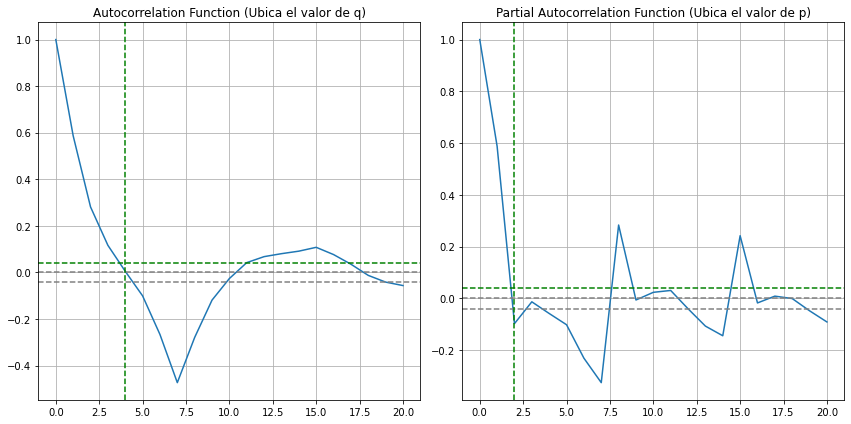

In [19]:
#Aplicamos ARIMA a la serie de tiempo de temperatura máxima
lag_acf = acf(ts_TmaxLog_diff, nlags=20)
lag_pacf = pacf(ts_TmaxLog_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_TmaxLog_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_TmaxLog_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_TmaxLog_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_TmaxLog_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

Observamos que p=4, y q=2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2189
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4390.127
Method:                       css-mle   S.D. of innovations              0.033
Date:                Tue, 09 Mar 2021   AIC                          -8772.255
Time:                        22:38:14   BIC                          -8749.490
Sample:                             1   HQIC                         -8763.934
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           1.9e-05      0.001      0.038      0.970      -0.001       0.001
ar.L1.D.Tmax    -0.1945      0.021     -9.256      0.000      -0.236      -0.153
ar.L2.D.Tmax    -0.1854      0.021     -8.82

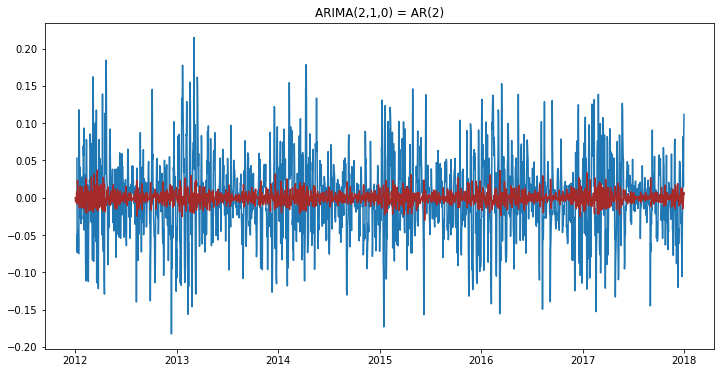

In [20]:
#Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_TmaxLog, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_TmaxLog_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2189
Model:                 ARIMA(0, 1, 4)   Log Likelihood                4507.685
Method:                       css-mle   S.D. of innovations              0.031
Date:                Tue, 09 Mar 2021   AIC                          -9003.370
Time:                        22:38:17   BIC                          -8969.223
Sample:                             1   HQIC                         -8990.889
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.256e-06      0.000      0.034      0.973      -0.000       0.000
ma.L1.D.Tmax    -0.3164      0.021    -14.782      0.000      -0.358      -0.274
ma.L2.D.Tmax    -0.2467      0.022    -11.22

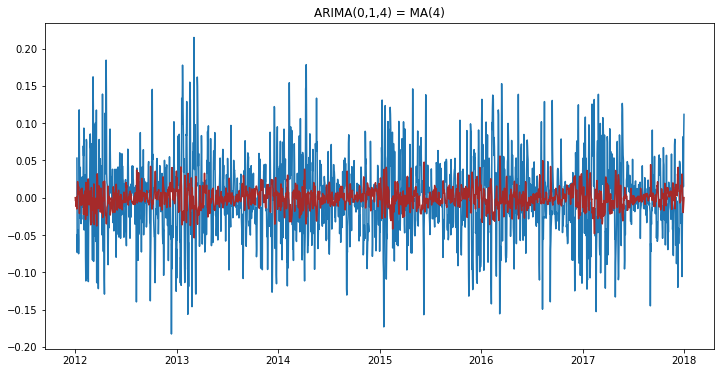

In [21]:
#Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_TmaxLog, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_TmaxLog_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2189
Model:                 ARIMA(2, 1, 4)   Log Likelihood                4510.055
Method:                       css-mle   S.D. of innovations              0.031
Date:                Tue, 09 Mar 2021   AIC                          -9004.111
Time:                        22:38:22   BIC                          -8958.581
Sample:                             1   HQIC                         -8987.469
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.319e-06      0.000      0.034      0.973      -0.000       0.000
ar.L1.D.Tmax    -0.6301      0.130     -4.834      0.000      -0.886      -0.375
ar.L2.D.Tmax     0.1497      0.115      1.29

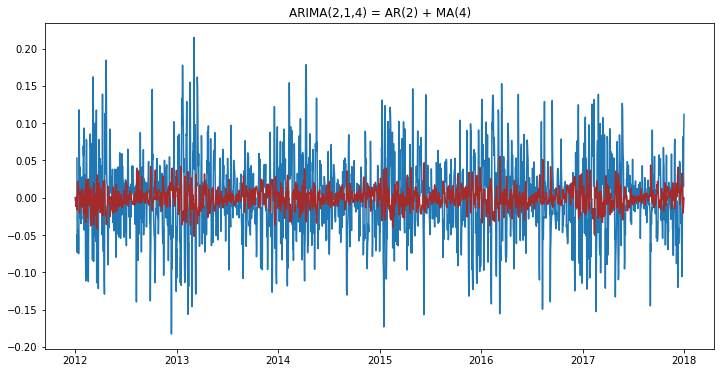

In [22]:
#Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_TmaxLog, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_TmaxLog_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())



1.   AR: AIC = -8772.255
2.   MA: AIC = -9003.370
3.   ARIMA: AIC = -9004.111

El modelo más adecuado es el ARIMA debido a que el valor del AIC es menor.



In [23]:
#Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2012-01-02    0.000005
2012-01-03   -0.004340
2012-01-04   -0.002829
2012-01-05   -0.011817
2012-01-06   -0.006642
                ...   
2017-12-27   -0.003223
2017-12-28   -0.020509
2017-12-29   -0.011927
2017-12-30   -0.005481
2017-12-31   -0.000489
Length: 2189, dtype: float64


In [24]:
#Le sumamos las predicciones de ARIMA a la serie observada
predictions_ARIMA_log = pd.Series(ts_TmaxLog, index = ts_TmaxLog.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
2012-01-01         NaN
2012-01-02    1.431369
2012-01-03    1.415616
2012-01-04    1.459569
2012-01-05    1.425934
dtype: float64
Fecha
2017-12-27    1.462159
2017-12-28    1.418824
2017-12-29    1.416208
2017-12-30    1.409492
2017-12-31    1.463404
dtype: float64


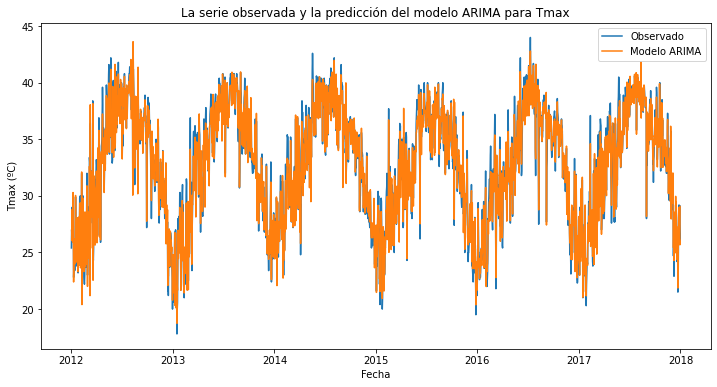

In [25]:
#Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_Tmax, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [26]:
#Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_Tmax)**2))
print('RMSE:', RMSE)

RMSE: 0.9481756934265244


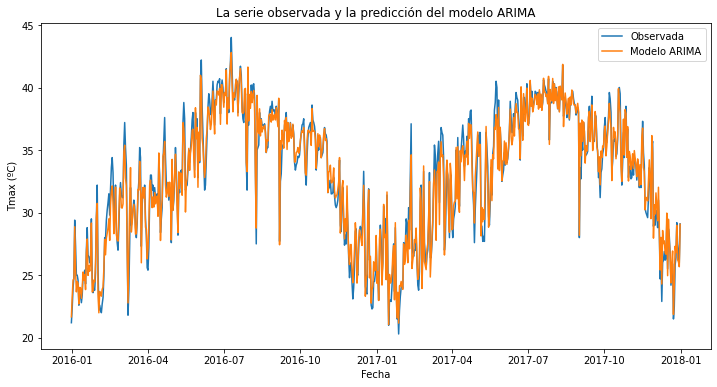

In [27]:
#Graficamos sólo los útimos datos de las series 
ts_TmaxLast = ts_Tmax.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_TmaxLast, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

***Temperatura mínima***

In [28]:
#Diferenciamos usando la función df.shift(), y eliminamos valores nulos
ts_TminLog_diff = ts_TminLog - ts_TminLog.shift(periods=7)
ts_TminLog_diff.dropna(inplace=True)

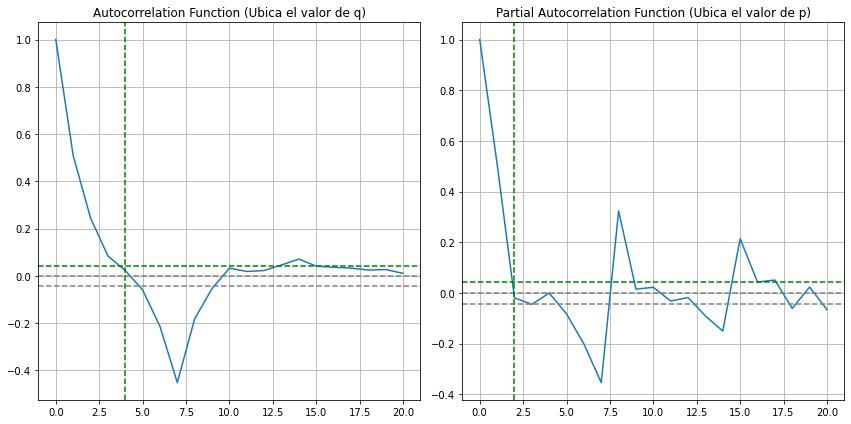

In [29]:
#Aplicamos ARIMA a la serie de tiempo de temperatura máxima
lag_acf = acf(ts_TminLog_diff, nlags=20)
lag_pacf = pacf(ts_TminLog_diff, nlags=20, method = 'ols')

#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

#Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_TminLog_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_TminLog_diff)), linestyle='--', color='green')
#Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

#Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_TminLog_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_TminLog_diff)), linestyle='--', color='green')
#Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

Observamos que p=4, y q=2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2189
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4390.127
Method:                       css-mle   S.D. of innovations              0.033
Date:                Tue, 09 Mar 2021   AIC                          -8772.255
Time:                        22:38:38   BIC                          -8749.490
Sample:                             1   HQIC                         -8763.934
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           1.9e-05      0.001      0.038      0.970      -0.001       0.001
ar.L1.D.Tmax    -0.1945      0.021     -9.256      0.000      -0.236      -0.153
ar.L2.D.Tmax    -0.1854      0.021     -8.82

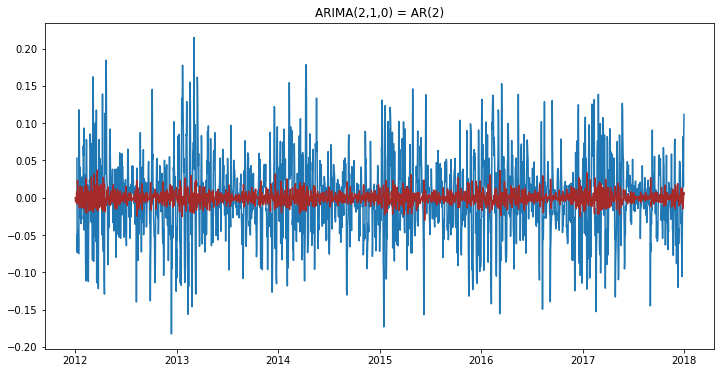

In [30]:
#Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_TmaxLog, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_TmaxLog_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2189
Model:                 ARIMA(0, 1, 4)   Log Likelihood                3542.853
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 09 Mar 2021   AIC                          -7073.705
Time:                        22:38:41   BIC                          -7039.558
Sample:                             1   HQIC                         -7061.224
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.088e-05      0.000      0.339      0.735      -0.000       0.001
ma.L1.D.Tmin    -0.4233      0.021    -19.758      0.000      -0.465      -0.381
ma.L2.D.Tmin    -0.1916      0.023     -8.35

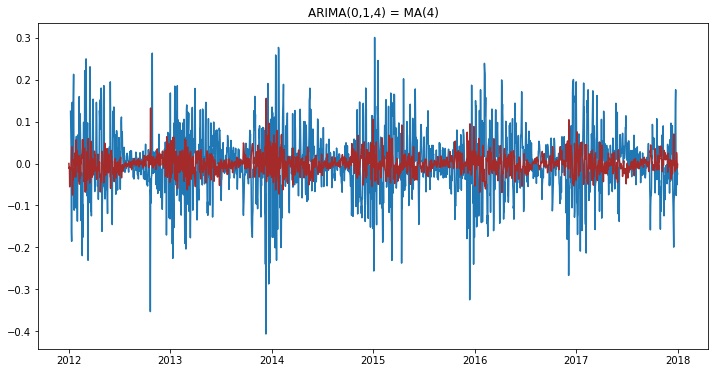

In [31]:
#Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_TminLog, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_TminLog_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2189
Model:                 ARIMA(2, 1, 4)   Log Likelihood                3543.884
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 09 Mar 2021   AIC                          -7071.767
Time:                        22:38:45   BIC                          -7026.238
Sample:                             1   HQIC                         -7055.126
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.088e-05      0.000      0.335      0.737      -0.000       0.001
ar.L1.D.Tmin    -0.6272      0.268     -2.344      0.019      -1.152      -0.103
ar.L2.D.Tmin    -0.0340      0.208     -0.16

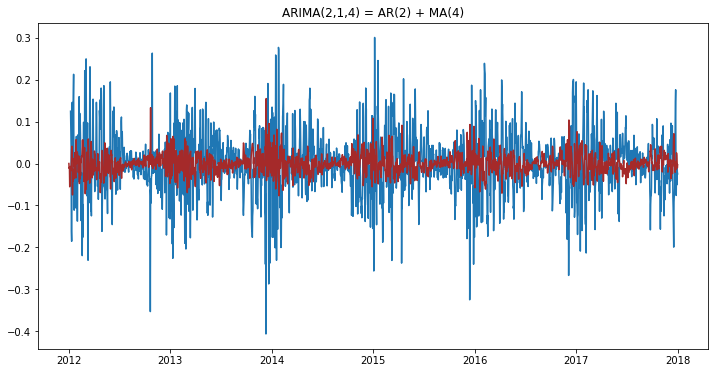

In [32]:
#Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_TminLog, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_TminLog_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

1.   AR: AIC = -8772.255
2.   MA: AIC = -7073.705
3.   ARIMA: AIC = -7071.767

El modelo más adecuado es el AR debido a que el valor del AIC es menor.

In [33]:
#Definimos una serie de tiempo con las predicciones obtenidas por el método AR
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_AR_diff)

Fecha
2012-01-02    0.000019
2012-01-03   -0.004331
2012-01-04   -0.002673
2012-01-05   -0.006113
2012-01-06   -0.003047
                ...   
2017-12-27   -0.012932
2017-12-28   -0.010339
2017-12-29   -0.003022
2017-12-30    0.007033
2017-12-31    0.004661
Length: 2189, dtype: float64


In [34]:
#Le sumamos las predicciones de ARIMA a la serie observada
predictions_AR_log = pd.Series(ts_TminLog, index = ts_TminLog.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff)
print(predictions_AR_log.head())
print(predictions_AR_log.tail())

Fecha
2012-01-01         NaN
2012-01-02    1.000019
2012-01-03    0.995669
2012-01-04    1.137206
2012-01-05    1.133766
dtype: float64
Fecha
2017-12-27    1.163159
2017-12-28    1.193781
2017-12-29    1.237527
2017-12-30    1.227141
2017-12-31    1.235110
dtype: float64


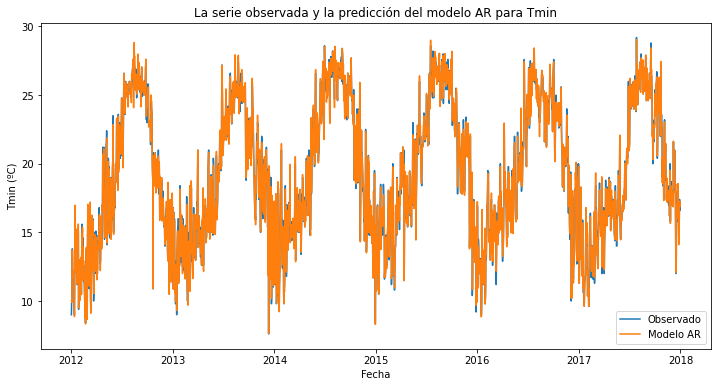

In [35]:
#Regresamos a la escala de Temperatura original 
predictions_AR = 10**(predictions_AR_log)
# Graficamos la serie original y las predicciones con ARIMA

#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_Tmin, label='Observado');
plt.plot(predictions_AR, label='Modelo AR');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo AR para Tmin')
plt.legend(loc='best');

In [36]:
#Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)
RMSE = np.sqrt(np.mean((predictions_AR - ts_Tmin)**2))
print('RMSE:', RMSE)

RMSE: 0.33720336303199905


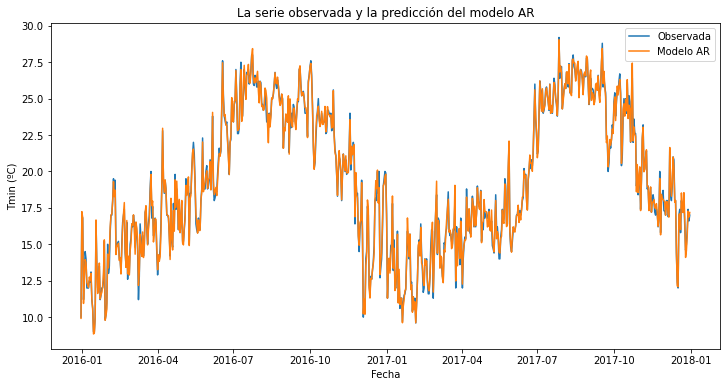

In [37]:
# Graficamos sólo los útimos datos de las series 
ts_TminLast = ts_Tmin.tail(730)
predictions_AR_last = predictions_AR.tail(730)
plt.plot(ts_TminLast, label='Observada');
plt.plot(predictions_AR_last, label='Modelo AR');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo AR')
plt.legend(loc='best');